# Autoencoders for Anomaly Detection

In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

Note: This Colab is adapted from the tensorflow [Intro to Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder) example.

### Import TensorFlow and other libraries

In [1]:
import subprocess
import tensorflow as tf
import numpy as np

# Desired versions
tf_version = "2.19.0"
hub_version = "0.16.0"
datasets_version = "4.6.0"
numpy_version = "1.26.4"
protobuf_version = "3.20.3"

# Try importing optional packages
try:
    import tensorflow_hub as hub
except ImportError:
    hub = None

try:
    import tensorflow_datasets as tfds
except ImportError:
    tfds = None

# Helper to install a specific version of a package
def install_package(package, version):
    subprocess.check_call(["pip", "install", f"{package}=={version}"])

# Helper to uninstall multiple packages
def uninstall_packages(packages):
    subprocess.check_call(["pip", "uninstall", "-y"] + packages)

# Version mismatch check
version_mismatch = (
    tf.__version__ != tf_version or
    (hub and hub.__version__ != hub_version) or
    (tfds and tfds.__version__ != datasets_version) or
    not np.__version__.startswith(numpy_version)
)

# Act on mismatches
if version_mismatch:
    print(f"TensorFlow: {tf.__version__} → {tf_version}")
    if hub: print(f"TensorFlow Hub: {hub.__version__} → {hub_version}")
    if tfds: print(f"TensorFlow Datasets: {tfds.__version__} → {datasets_version}")
    print(f"NumPy: {np.__version__} → {numpy_version}")

    uninstall_packages([
        "tensorflow", "tensorflow_hub", "tensorflow_datasets",
        "numpy", "protobuf"
    ])

    install_package("tensorflow", tf_version)
    install_package("tensorflow_hub", hub_version)
    install_package("tensorflow_datasets", datasets_version)
    install_package("numpy", numpy_version)
    install_package("protobuf", protobuf_version)

    print("\n Required versions installed successfully.")
    print("Please restart the runtime (Runtime > Restart session) and re-run the notebook.")
else:
    print("All packages are already at the specified versions.")

All packages are already at the specified versions.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [3]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [5]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]` to improve training accuracy.


In [6]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [7]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

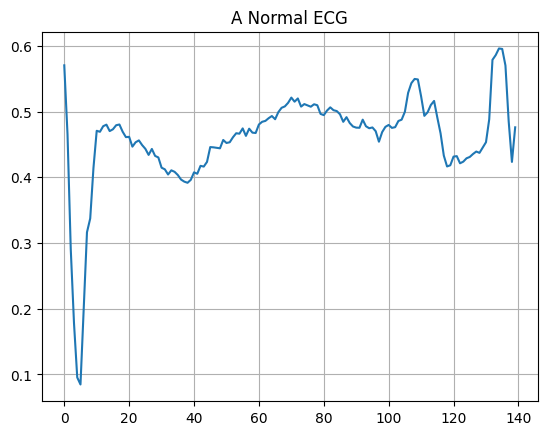

In [8]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

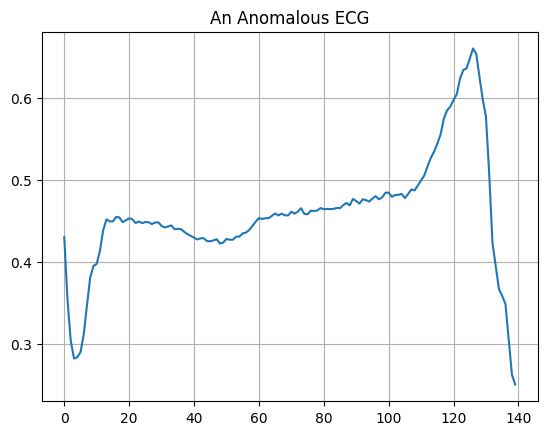

In [9]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

After training and evaluating the example model, try modifying the size and number of layers to build an understanding for autoencoder architectures.

Note: Changing the size of the embedding (the smallest layer) can produce interesting results. Feel free to play around with that layer size.

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")]) # Smallest Layer Defined Here

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [11]:
autoencoder.compile(optimizer='adam', loss='mae')

### Train the model

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [12]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - loss: 0.0586 - val_loss: 0.0530
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0562 - val_loss: 0.0515
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0534 - val_loss: 0.0495
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0496 - val_loss: 0.0483
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0456 - val_loss: 0.0462
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0413 - val_loss: 0.0439
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0377 - val_loss: 0.0425
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0345 - val_loss: 0.0407
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0321 - val_loss: 0.0397
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0303 - val_loss: 0.0389
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0289 - val_loss: 0.0379
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0276 - val_loss: 0.0370


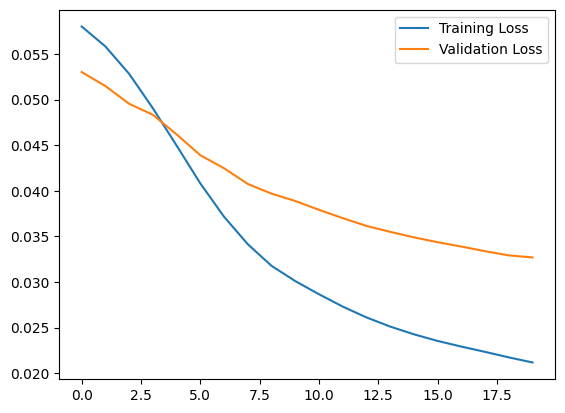

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Evaluate Training

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

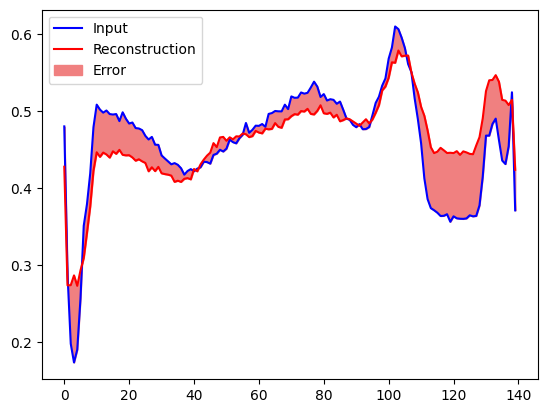

In [14]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

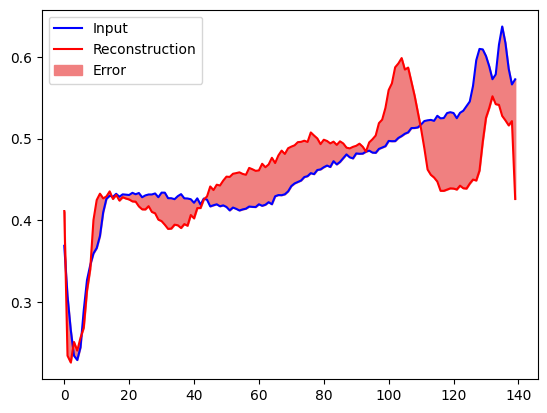

In [15]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


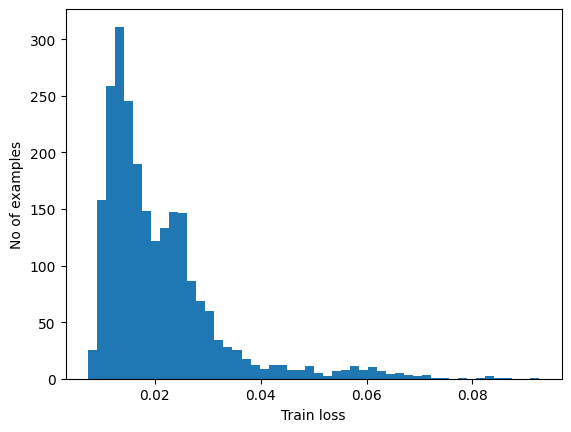

In [16]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [17]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032087088


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You will learn more later in the colab.

If you examine the recontruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


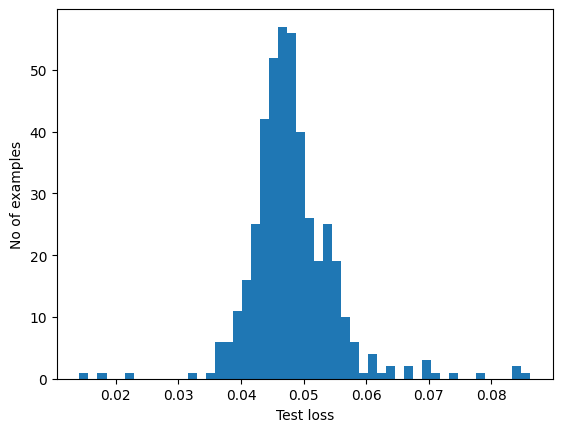

In [18]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [19]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [20]:
preds, scores = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.942
Precision = 0.9940944881889764
Recall = 0.9017857142857143


### ROC and AUC Metrics

We've created a fairly accurate model for anomaly detection but our accuracy is highly dependant on the threshold we select.

What if we wanted to evaluate how different thresholds impact our true positive and false positive rates?

Enter Receiver Operating Characteristic (ROC) plots! This metric allows us to visualize the tradeoff between predicting anomalies as normal (false positives) and predicting normal data as an anomaly (false negative). Remember that normal rhythms are labeled as `1` in this dataset.  

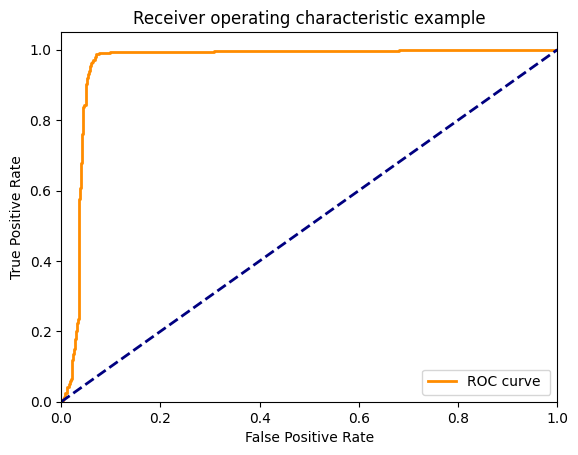

In [21]:
fpr = []
tpr = []
#the test labels are flipped to match how the roc_curve function expects them.
flipped_labels = 1-test_labels
fpr, tpr, _ = roc_curve(flipped_labels, scores)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


Since our model does a great job in diferentiating normal rythms from abnormal ones it seems easy to pick the threshold that would give us the high true positive rate (TPR) and low false positive rate (FPR) that is at the 'knee' of the curve.

However, in some cases there may be an application constraint that requires a specific TPR or FPR, in which case we would have to move off of the 'knee' and sacrifice overall accuracy. In this case we might rather have false alarms than miss a potentially dangerous rythm.

Now that we understand how to visualize the impact of the selected threshold, What if we wanted to compare the performance of models without factoring in the threshold? Simply comparing the accuracy won't work since that depends on the threshold you pick and that won't have the same impact across models.

Instead we can measure the area under the curve (AUC) in the ROC plot. One way to interpret the AUC metric is as the probability that the model ranks a random positive example more highly than a random negative example.

In general the AUC is a useful metic for comparison as it is threshold invariant *and* scale invariant

In [22]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9598944805194806


## Links to Continue Learning

If you would like to learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow.

To learn more about the basics of autoencoders, try the basis for this colab, [TensorFlow's Intro to Autoencoders](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb#scrollTo=xfNT-mlFwxVM)

For more info, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet, and check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
